# Give Me Some Credit

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit.

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

Evaluation - AUC

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from phik.report import plot_correlation_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
data = pd.read_csv('D:\Files\Portfolio Data Science\ECL\give-me-some-credit\data\cs-training.csv', index_col=0)
test_data = pd.read_csv('D:\Files\Portfolio Data Science\ECL\give-me-some-credit\data\cs-test.csv', index_col=0)

In [3]:
# dictionary for renaming columns
rename_dict = {
    'SeriousDlqin2yrs': 'target',
    'RevolvingUtilizationOfUnsecuredLines': 'revolving_utilization',
    'NumberOfTime30-59DaysPastDueNotWorse': 'past_due_30_59',
    'DebtRatio': 'debt_ratio',
    'MonthlyIncome': 'monthly_income',
    'NumberOfOpenCreditLinesAndLoans': 'open_credit_lines',
    'NumberOfTimes90DaysLate': 'past_due_90_plus',
    'NumberRealEstateLoansOrLines': 'real_estate_loans',
    'NumberOfTime60-89DaysPastDueNotWorse': 'past_due_60_89',
    'NumberOfDependents': 'dependents'
}

data.rename(columns=rename_dict, inplace=True)
test_data.rename(columns=rename_dict, inplace=True)

display(data.head())
display(test_data.head())

,target,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


,target,revolving_utilization,age,past_due_30_59,debt_ratio,monthly_income,open_credit_lines,past_due_90_plus,real_estate_loans,past_due_60_89,dependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [4]:
# train and test model before data analysis
X = data.drop('target', axis=1).fillna(0)
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

model = LogisticRegression(max_iter=5000)
model.fit(X_train, y_train)

y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("Train ROC-AUC:", round(roc_auc_score(y_train, y_train_pred_proba), 4))

y_pred_proba = model.predict_proba(X_val)[:, 1]
print("ROC-AUC:", round(roc_auc_score(y_val, y_pred_proba), 4))

Train ROC-AUC: 0.693
ROC-AUC: 0.7089


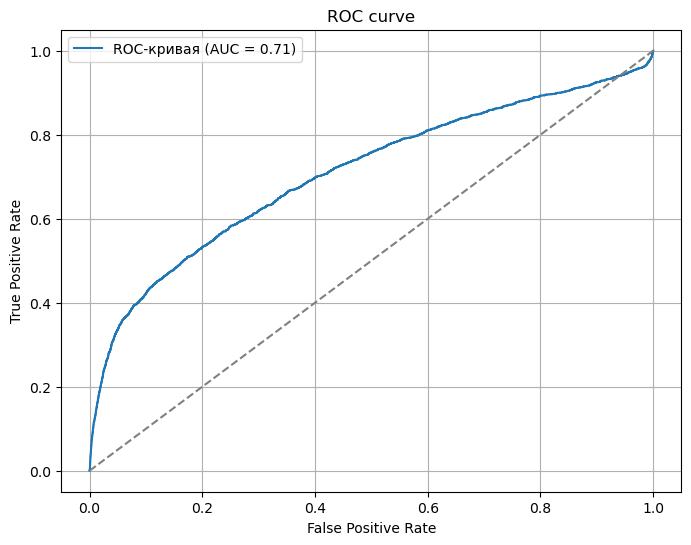

In [5]:
# Building a ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-кривая (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.grid(True)
plt.show()

We trained and tested the model on raw data without preprocessing to check the quality after preprocessing. The result of the ROC metric on training data is 0.69 and on test data 0.71. Let's try to improve the results.

## Exploratory Data Analysis

In [6]:
data_eda = data.copy()
data_eda.info()
data_eda.describe().T

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   target                 150000 non-null  int64  
 1   revolving_utilization  150000 non-null  float64
 2   age                    150000 non-null  int64  
 3   past_due_30_59         150000 non-null  int64  
 4   debt_ratio             150000 non-null  float64
 5   monthly_income         120269 non-null  float64
 6   open_credit_lines      150000 non-null  int64  
 7   past_due_90_plus       150000 non-null  int64  
 8   real_estate_loans      150000 non-null  int64  
 9   past_due_60_89         150000 non-null  int64  
 10  dependents             146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.7 MB


,count,mean,std,min,25%,50%,75%,max
target,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
revolving_utilization,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
past_due_30_59,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
debt_ratio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
monthly_income,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
open_credit_lines,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
past_due_90_plus,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
real_estate_loans,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
past_due_60_89,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


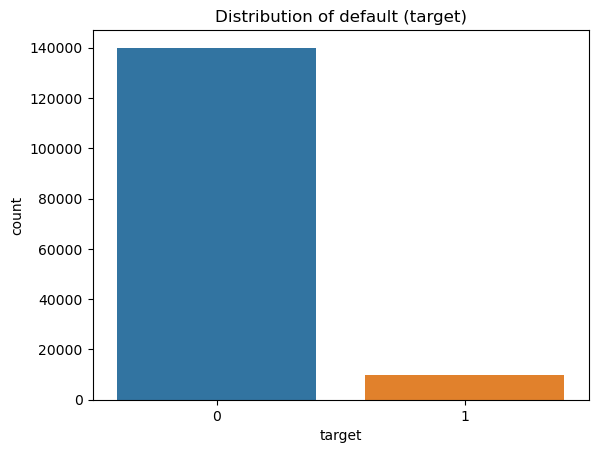

target
0    0.93316
1    0.06684
Name: proportion, dtype: float64


In [7]:
sns.countplot(x='target', data=data_eda)
plt.title('Distribution of default (target)')
plt.show()

print(data['target'].value_counts(normalize=True))

📊 **General Structure:**
- 150,000 rows, 11 features
- Target variable `target` is imbalanced with a slight skew: \~6.7% defaults
- 2 features contain missing values:
    - `monthly_income`: \~20% missing
    - `dependents`: \~2.6% missing
 
⚠️ **Suspicious Values and Outliers:**
- `age`: minimum = 0 — not possible, data error
- `revolving_utilization`: max = 50,708.0 — over 5,000,000% usage rate, anomaly
- `debt_ratio`: max = 329,664.0 — also an anomaly
- `monthly_income`: max = 3,008,750.0 — most likely an outlier
- `past_due_*`: max = 98 — likely a coded value (e.g., "98 or more"), needs verification

🧮 **Distributions:**
- open_credit_lines, real_estate_loans, dependents — reasonable ranges
- past_due_30_59, past_due_60_89, past_due_90_plus — mostly 0s, but extreme values up to 98

**Conclusion:**
- Significant outliers in numeric features — requires handling (e.g., clip, log-transform, or winsorization)
- Missing values should be filled (e.g., with median or a separate category)
- `target` is imbalanced → consider this during modeling (e.g., `class_weight='balanced'` in classifiers)

##### age: there are values <18 - this is an error, we will delete such lines

In [8]:
data_eda = data_eda[data_eda['age'] >= 18]

##### Upper percentile outlier limitation

In [9]:
# Extreme values limit
def cap_outliers(df, column, upper_quantile=0.99):
    cap = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(upper=cap)

for col in ['revolving_utilization', 'debt_ratio', 'monthly_income']:
    cap_outliers(data_eda, col)

<Axes: >

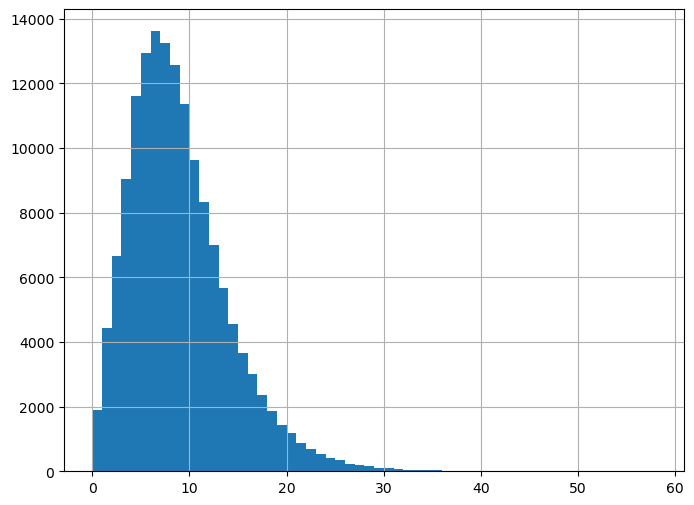

In [10]:
data_eda['open_credit_lines'].hist(bins=58, figsize=(8, 6))

In [11]:
# Removing clients with open_credit_lines > 30
data_eda = data_eda[data_eda['open_credit_lines'] <= 30]

##### Processing past_due_* variables

In [12]:
for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
    print(f"\n{col} value counts:")
    print(data_eda[col].value_counts().sort_index())


past_due_30_59 value counts:
past_due_30_59
0     125736
1      15984
2       4585
3       1748
4        747
5        339
6        139
7         54
8         24
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: count, dtype: int64

past_due_60_89 value counts:
past_due_60_89
0     142050
1       5724
2       1117
3        318
4        105
5         34
6         16
7          9
8          1
9          1
11         1
96         5
98       264
Name: count, dtype: int64

past_due_90_plus value counts:
past_due_90_plus
0     141314
1       5238
2       1555
3        667
4        290
5        131
6         79
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: count, dtype: int64


In [13]:
# limiting past_due_*
for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
    data_eda[col] = data_eda[col].clip(upper=10)

##### Filling in the data gaps

In [14]:
# Filling in the blanks with the median for monthly_income and 0 for dependents (let's say "no dependents")
data_eda['monthly_income'] = data_eda['monthly_income'].fillna(data_eda['monthly_income'].median())
data_eda['dependents'] = data_eda['dependents'].fillna(0)

##### Post-processing check:

In [15]:
data_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
target,149645.0,0.066825,0.249719,0.0,0.000000,0.000000,0.000000,1.000000
revolving_utilization,149645.0,0.320673,0.352327,0.0,0.029853,0.154233,0.559583,1.092958
age,149645.0,52.282088,14.777024,21.0,41.000000,52.000000,63.000000,109.000000
past_due_30_59,149645.0,0.263043,0.809197,0.0,0.000000,0.000000,0.000000,10.000000
debt_ratio,149645.0,316.538349,906.579569,0.0,0.174803,0.366056,0.868453,4979.080000
monthly_income,149645.0,6153.542771,3911.930173,0.0,3900.000000,5400.000000,7375.000000,25000.000000
open_credit_lines,149645.0,8.387804,4.966981,0.0,5.000000,8.000000,11.000000,30.000000
past_due_90_plus,149645.0,0.108076,0.635930,0.0,0.000000,0.000000,0.000000,10.000000
real_estate_loans,149645.0,1.013632,1.100112,0.0,0.000000,1.000000,2.000000,23.000000
past_due_60_89,149645.0,0.082716,0.534314,0.0,0.000000,0.000000,0.000000,10.000000


✅ 1. Missing values processed
- monthly_income: missing values (≈20% of the sample) were replaced with the median (5400.0), which allowed us to preserve the distribution and avoid bias.
- dependents: missing values were replaced with 0 — it is logical to interpret this as the absence of dependents.

✅ 2. Outliers and anomalies processed
- revolving_utilization: the maximum value is now 1.09, it used to be 50708 — this means that extreme outliers have been removed or limited.
- debt_ratio: the maximum is now 4979, it used to be 329664 — extreme values have also been processed.
- past_due_* variables (30-59, 60-89, 90+):
- maximums are now 10, instead of 98 — assumed code values (e.g. 96, 98) have been replaced with realistic values within the variable logic.

✅ 3. Distributions look adequate
- Most variables have reasonable values:
    - age: from 21 to 109 years old, which corresponds to the real age sample.
    - open_credit_lines: on average ~8, maximum 58 — acceptable.
    - real_estate_loans: on average 1, maximum 54 — perhaps the extreme values should be double-checked.
- past_due_* variables now reflect the real delinquency rate: average values are low, median = 0.

#### Distribution

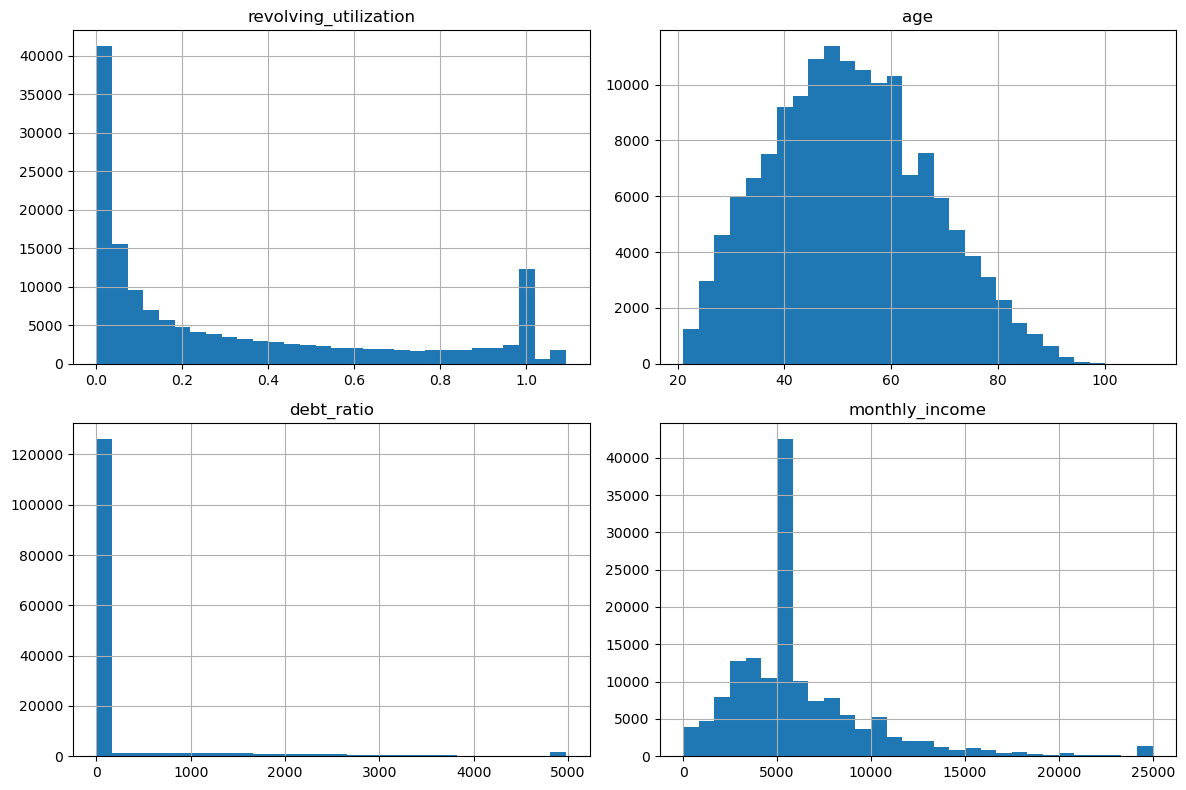

In [16]:
continuous = ['revolving_utilization', 'age', 'debt_ratio', 'monthly_income']
data_eda[continuous].hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

Key features:
- Distributions became realistic and limited, without anomalies.
- revolving_utilization — skewed to the left, with a peak around 0; reasonable maximum ~1.
- age — symmetrically distributed with a peak at ~50 years.
- debt_ratio — strongly skewed to the right, but outliers removed; the bulk is up to 500.
- monthly_income — peak value ~5000; abnormally high incomes removed.

📌 Conclusion: after cleaning, the features became suitable for modeling and visual analysis.

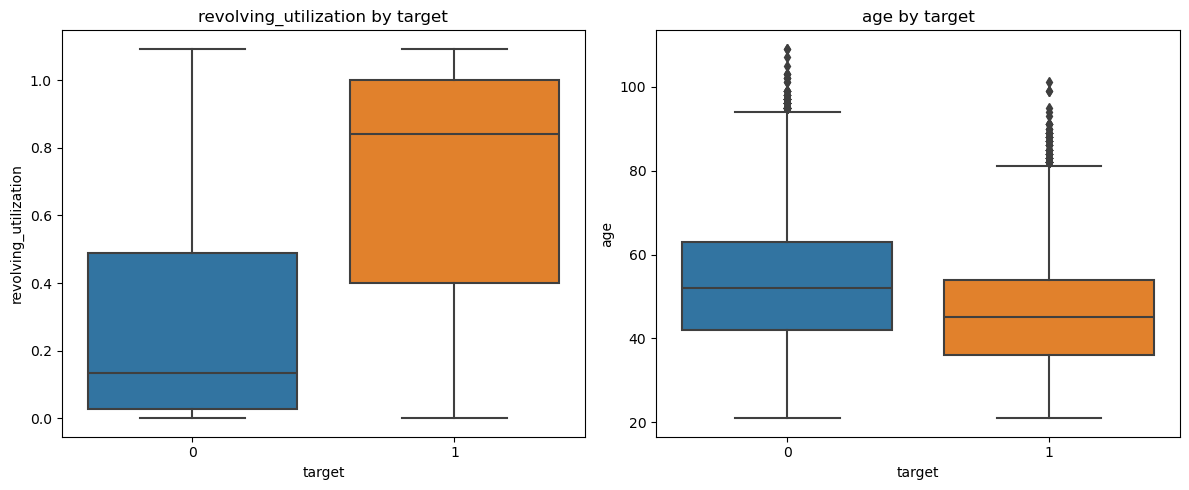

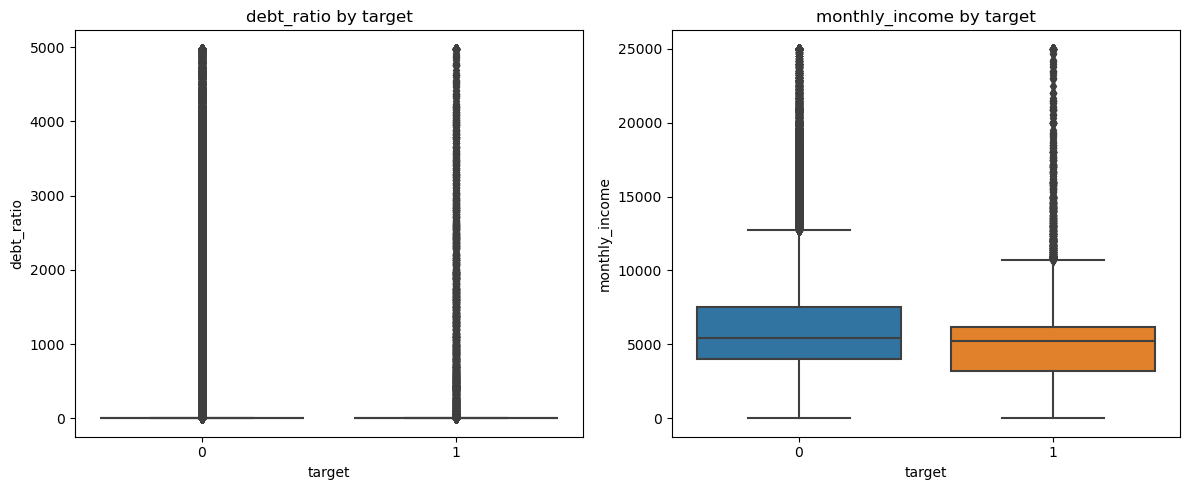

In [17]:
for i in range(0, len(continuous), 2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for j in range(2):
        if i + j < len(continuous):
            sns.boxplot(
                x='target',
                y=continuous[i + j],
                data=data_eda,
                ax=axes[j]
            )
            axes[j].set_title(f"{continuous[i + j]} by target")
    plt.tight_layout()
    plt.show()

Observations:
- revolving_utilization: defaulting clients have a significantly higher median.
- age: defaulting clients are younger than solvent clients.
- debt_ratio: the difference between classes is insignificant.
- monthly_income: defaulting clients have a slightly lower median, but the overlap is large.

📌 Conclusion:
- revolving_utilization and age are informative features.
- debt_ratio and monthly_income are weaker, but potentially useful.

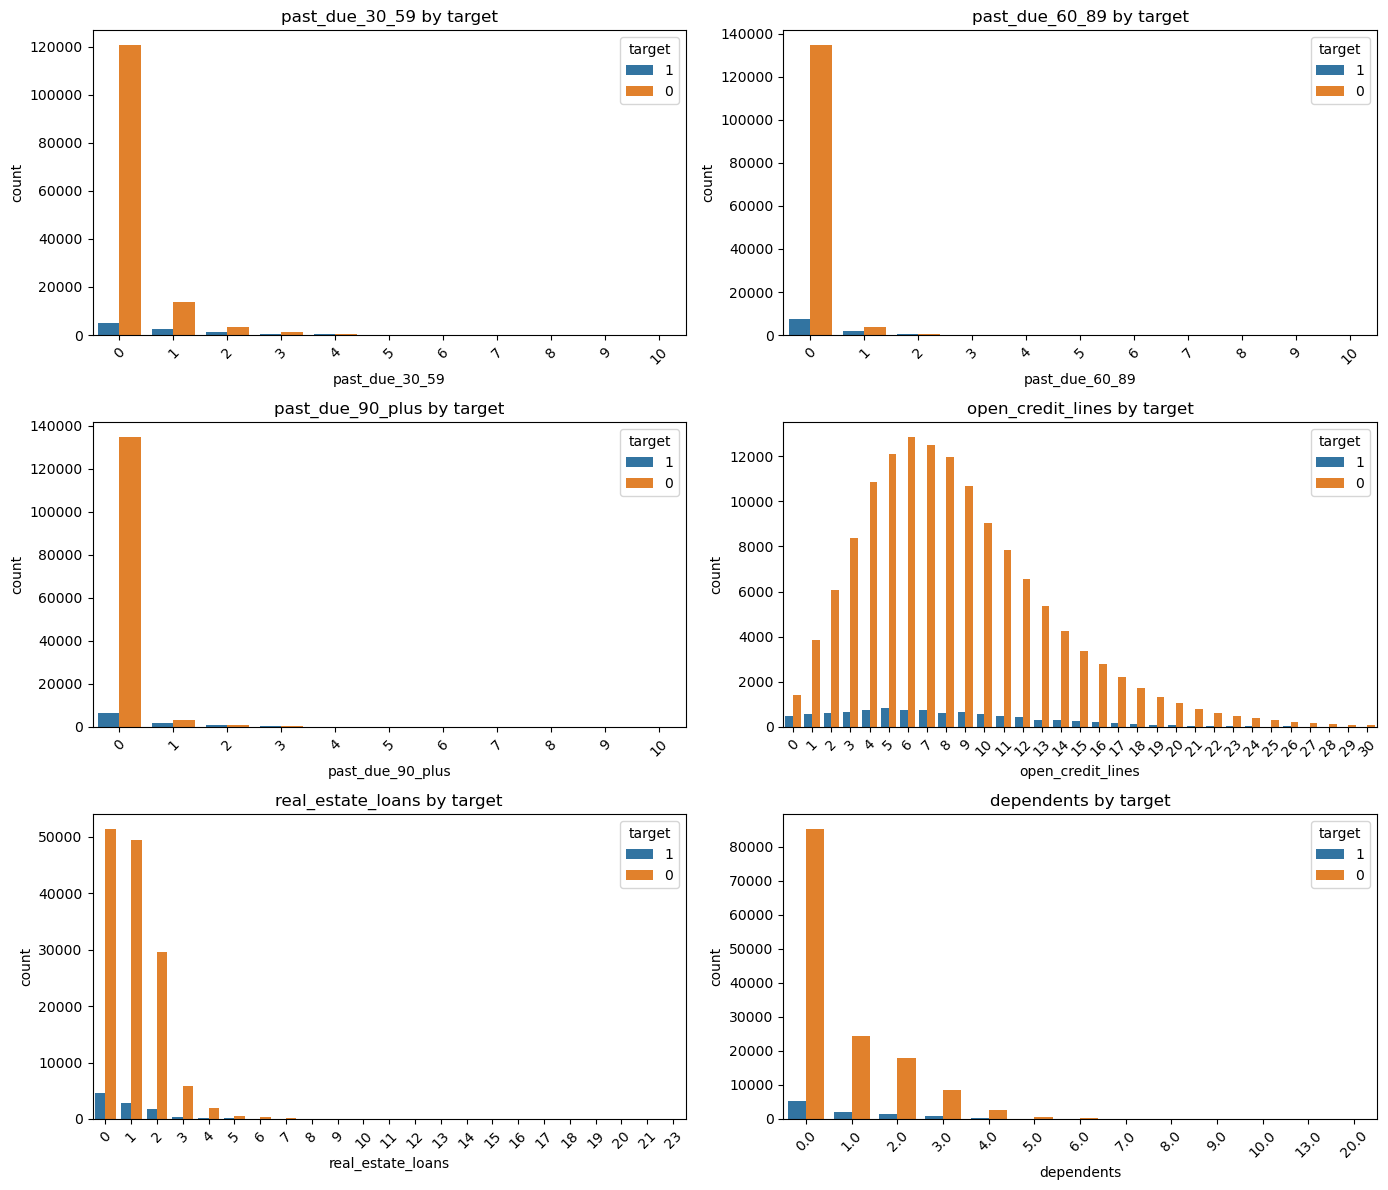

In [18]:
# Convert target to string for correct legend
data_eda['target'] = data_eda['target'].astype(str)

categorical = ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus',
               'open_credit_lines', 'real_estate_loans', 'dependents']

# Number of rows and columns of graphs
n_cols = 2
n_rows = (len(categorical) + 1) // n_cols

# Size of the whole figure
plt.figure(figsize=(14, 4 * n_rows))

for i, col in enumerate(categorical, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=data_eda, x=col, hue='target')
    plt.title(f'{col} by target')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Returning data type integer
data_eda['target'] = data_eda['target'].astype(int)

Key observations:
- past_due_*: with delinquencies (>0), the share of defaulters increases sharply.
- open_credit_lines: defaults are more common with a small number of loans (1–5).
- real_estate_loans: defaults are more common with zero or one loan.
- dependents: weak relationship, but a small increase in defaults with 2+ dependents.

📌 Conclusion:
- past_due_* are strong predictors.
- open_credit_lines — can be useful in combination.
- real_estate_loans, dependents — weaker, can be simplified (binning or drop).

#### Correlations

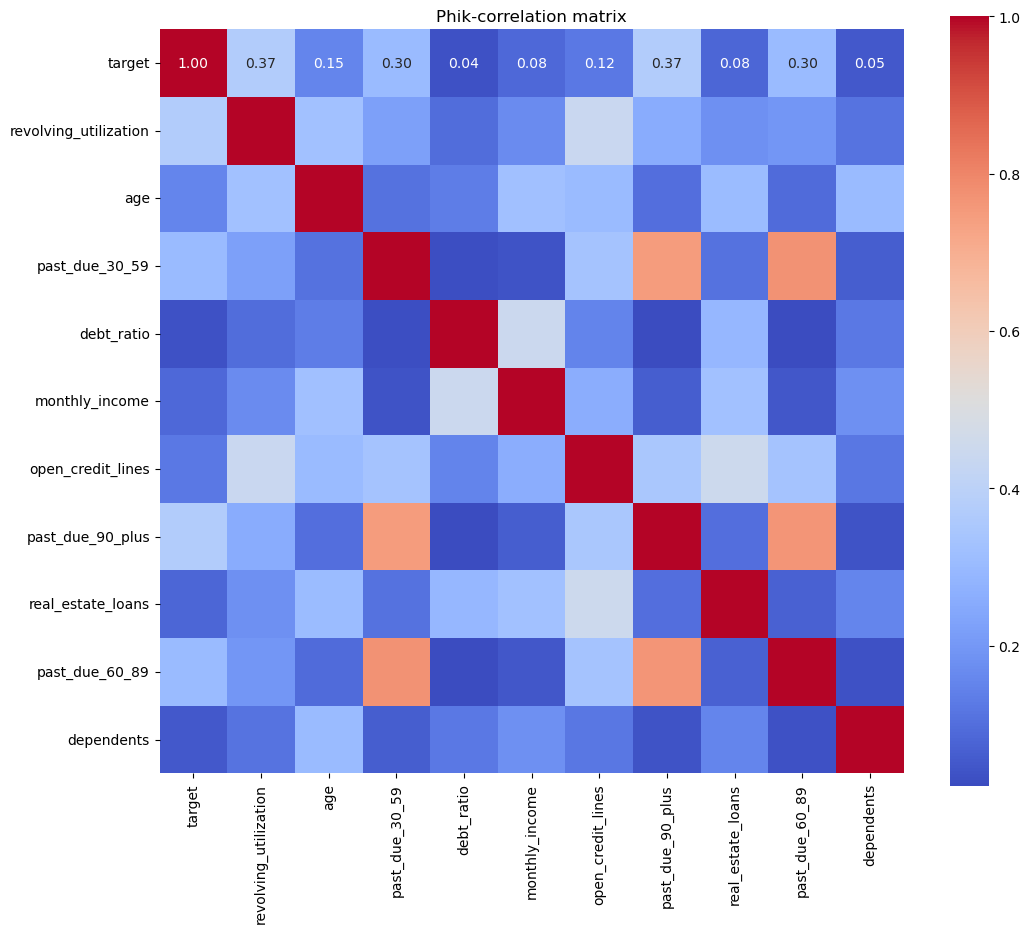

In [19]:
interval_cols = [
    'revolving_utilization',
    'age',
    'debt_ratio',
    'monthly_income'
]

# Calculation of the full correlation matrix
phik_corr = data_eda.phik_matrix(interval_cols=interval_cols)

# Heat-map
plt.figure(figsize=(12, 10))
sns.heatmap(
    phik_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True)
plt.title("Phik-correlation matrix")
plt.show()

📌 **Conclusions:**

The most important features for target:
- revolving_utilization
- past_due_90_plus, past_due_30_59, past_due_60_89
- age (moderate)

Weak features (can be removed during model optimization):
- dependents, real_estate_loans, debt_ratio

There are highly correlated groups, especially among delinquencies - should be reduced or combined.
monthly_income is related to other features, but weakly to target - there may be a nonlinear dependence.

## Logistic regression model for predicting target feature

Since the data is unbalanced: there are more good clients than bad ones, we use the ROC-AUC quality metric. This is a standard metric for binary classification problems with unbalanced classes, especially in the banking sector (risk management, scoring).
Additionally, we use a pipeline for pre-processing so that the model can preprocess on test data as well.

In [20]:
# prepairing for pre-processing
target = 'target'
features = data.columns.drop(target).tolist()

def clean_features(X):
    X = X.copy()

    # age - cannot be less than 18
    X['age'] = X['age'].clip(lower=18)

    # limiting extreme values
    for col in ['revolving_utilization', 'debt_ratio', 'monthly_income']:
        upper = X[col].quantile(0.99)
        X[col] = X[col].clip(upper=upper)

    # open_credit_lines: max 30
    X['open_credit_lines'] = X['open_credit_lines'].clip(upper=30)

    # past_due: max 10
    for col in ['past_due_30_59', 'past_due_60_89', 'past_due_90_plus']:
        X[col] = X[col].clip(upper=10)

    return X

In [21]:
# pre-processing using pipeline
preprocessing = Pipeline([
    ("clean_features", FunctionTransformer(clean_features, validate=False)),
    ("impute", ColumnTransformer([
        ("monthly_income_median", SimpleImputer(strategy="median"), ['monthly_income']),
        ("dependents_zero", SimpleImputer(strategy="constant", fill_value=0), ['dependents']),
    ], remainder='passthrough')),
    ("scaler", StandardScaler())
])

model_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("classifier", LogisticRegression(max_iter=3000))
])

In [22]:
# train-test split
X = data.drop(columns=target)
y = data[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42)

In [23]:
# model training and prediction
model_pipeline.fit(X_train, y_train)

y_train_proba = model_pipeline.predict_proba(X_train)[:, 1]
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", round(roc_auc_score(y_train, y_train_proba), 4))
print("Validation ROC-AUC:", round(roc_auc_score(y_val, y_val_proba), 4))

Train ROC-AUC: 0.8407
Validation ROC-AUC: 0.8471


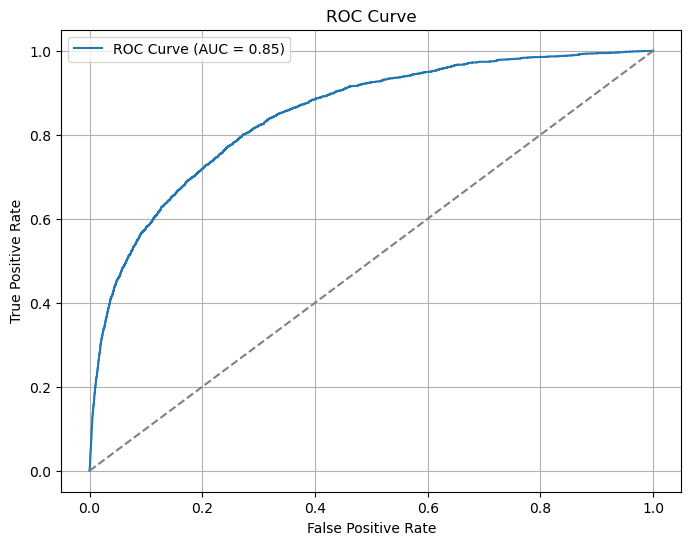

In [24]:
# ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

📌 The metric value of 0.85 is quite good. This means that with a probability of 84% the model correctly distinguishes a client who will not repay the loan from one who will. A close value for both the training set and the test set means that there are no problems with overfitting.

In [25]:
# Prediction on the final sample
X_test = test_data.drop(columns=['target'], errors='ignore').fillna(0)
test_proba = model.predict_proba(X_test)[:, 1]

# Save the result
submission = pd.DataFrame({
    'Id': X_test.index,
    'Probability': test_proba
})
submission.to_csv('submission.csv', index=False)
print("Predictions are saved in submission.csv")

Predictions are saved in submission.csv


## ✅ Project Summary: Credit Default Prediction

### 📌 Objective:
Build a model to predict whether a client will default on their loan in the next 2 years, using the **"Give Me Some Credit"** dataset from Kaggle.

### 1. **Initial Setup & Baseline Model**
- Loaded training (`cs-training.csv`) and test (`cs-test.csv`) datasets.
- Renamed columns for readability and consistency.
- Built a **Logistic Regression** model using the raw data:
    - **Train ROC-AUC**: `0.6930`
    - **Validation ROC-AUC**: `0.7089`

The baseline performance was acceptable but not strong. Also, raw data had multiple issues that likely hindered performance.

### 2. **Exploratory Data Analysis (EDA)**

#### 🧮 Data Overview:
- **Rows**: 150,000
- **Features**: 11
- **Imbalance**: \~6.7% defaults (`target = 1`)

#### ⚠️ Key Data Issues Identified:

| Problem            | Details                                                                                                      |
| ------------------ | ------------------------------------------------------------------------------------------------------------ |
| **Missing values** | `monthly_income` (\~20%), `dependents` (\~2.6%)                                                              |
| **Invalid values** | `age = 0` is not realistic                                                                                   |
| **Outliers**       | `revolving_utilization`, `debt_ratio`, `monthly_income`, `past_due_*` had extreme or coded values (e.g., 98) |

### 3. **Data Cleaning & Preprocessing**

#### ✅ Fixes Implemented:

| Issue                    | Fix                                                                                                |
| ------------------------ | -------------------------------------------------------------------------------------------------- |
| `age = 0`                | Removed rows with age < 18                                                                         |
| **Outliers**             | Capped extreme values (`revolving_utilization`, `debt_ratio`, `monthly_income`) at 99th percentile |
| `past_due_* = 98`        | Capped at 10 (assuming "98 or more")                                                               |
| **Missing values**       | `monthly_income` → filled with **median**, `dependents` → filled with **0**                        |
| `open_credit_lines > 30` | Removed as likely outliers                                                                         |

### 4. **Feature Exploration & Correlation**
- Used **Phik correlation** to analyze mixed types (numeric + categorical).
- Key insights:
  - Most informative features: `revolving_utilization`, `past_due_*`, `age`
  - Weak predictors: `dependents`, `real_estate_loans`, `debt_ratio`
  - Some redundancy in delinquency-related features — potential for dimensionality reduction.

### 5. **Model Training (Post-Cleaning)**
- Re-trained **Logistic Regression** on the cleaned dataset.
- **Performance**:
  - **Train ROC-AUC**: `0.8407`
  - **Validation ROC-AUC**: `0.8471`

> 🟢 **Huge improvement** from baseline (\~0.71 → 0.85).
> 🔁 Train and test scores are close → **no overfitting** observed.


### 6. **Final Prediction and Submission**
- Used the trained model to predict probabilities for test set clients.
- Saved the results in the required **Kaggle format** (`Id`, `Probability`) → `submission.csv`.

### 🔚 Final Conclusion

- 🎯 **Significant improvements** were achieved through careful EDA, outlier treatment, and missing value imputation.
- 📈 The ROC-AUC increased from **0.71 to 0.85** — a **17% relative gain** in discriminatory power.
- 🧠 The model now reliably identifies risky clients and can be a useful tool in credit scoring or risk management pipelines.